<a href="https://colab.research.google.com/github/saranpan/All_Search_Algorithm_Game/blob/main/PokeStat_CV_%5BDataPrep%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PokeStat (Estimator)

In this project, we aim to develop a machine learning model that can predict the stats (HP, attack, defense, special attack, special defense, and speed) of Pokemon based on their appearance, as represented in image files. This model could be useful for Pokemon fans who want an unbiased, AI-based perspective on the stats of different Pokemon. To train the model, we will use a dataset containing image files and corresponding stats for a number of Pokemon. The model will be developed using a convolutional neural network (CNN) in PyTorch, and we will compare the performance of a model trained from scratch with one using a pretrained model like ResNet. The dataset will contain seven columns: image file, HP, attack, defense, special attack, special defense, and speed, with the image file being the predictor variable and the stats being the target variables. The model will use multi-task learning with six sigmoid activation functions at the output layer to predict each stat independently. The training, validation, and test sets will be drawn from different generations of Pokemon, with the training and validation sets coming from generations 1-8 and the test set coming from generation 9 (the newest generation in 2020). The metric used to evaluate the model's performance will be RMSE. There is a risk that the metric may go overflow.

(Updated 2/3/23) The artwork of gen 9 pokemon were released

## Data Collection

goal : Image , stats (atk,def,sp.atk,sp.def,speed)

In [ ]:
!pip -q install beautifulsoup4

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/PokeStat" # Everything will be done within this folder 

In [ ]:
# If you are a new user, your PATH folder will got created
try:
  os.mkdir(PATH)
except FileExistsError:
  print("The folder already exists")

In [ ]:
def test_scrape_case(name='tauros'):
    url = 'https://pokemondb.net/pokedex/' + name
    response = requests.get(url)

    if response.status_code != 200:
        raise ValueError(f'Request on pokemon { name } returned status code {response.status_code}')
    
    soup = BeautifulSoup(response.text)

    all_form = soup.find('div',class_='sv-tabs-panel-list')
    all_form_img_lst = all_form.find_all('img')
    return all_form_img_lst

test_scrape_case('venusaur')

[<img alt="Venusaur artwork by Ken Sugimori" fetchpriority="high" height="279" src="https://img.pokemondb.net/artwork/venusaur.jpg" width="360"/>,
 <img alt="Mega Venusaur artwork by Ken Sugimori" fetchpriority="high" height="262" src="https://img.pokemondb.net/artwork/venusaur-mega.jpg" width="360"/>]

In [ ]:
def import_data():
    """
    The reasons behind why we choose to use BeautifulSoup instead pd.read_html is:
        1. The column 'Name' contain one or two tags, if the row have two tags, then the name should contain at the first tag 
            Eg. Mega Venusaur instead of Venusaur Mega Venusaur
        2. Doing pdread_html is hard to be the medium for its link that contain its pic. so it's better to get that href from each row
    """
    url = 'https://pokemondb.net/pokedex/all'
    response = requests.get(url)

    if response.status_code != 200:
        raise ValueError(f'Request returned status code {response.status_code}')   

    soup = BeautifulSoup(response.text) 
    table = soup.find('table')
    rows = table.find_all('tr')[1:]   # We do not want the header rows

    row_lst = []

    for row in rows:
        col = row.find_all('td')
        assert len(col) == 10, f'number of columns in table in pokemondb is {len(col)}'
        
        national_id = col[0].text
        main_name = col[1].find('a').text

        specf_name = col[1].find('small')
        if specf_name is not None:
            main_name = specf_name.text

        ref = col[1].find('a')['href']

        hp,atk,def_,spatk,spdef,speed = col[4:10]
        hp,atk,def_,spatk,spdef,speed = hp.text,atk.text,def_.text,spatk.text,spdef.text,speed.text 
 

        dct = {'national_id': national_id , 'main_name' : main_name,
               'hp': hp,'attack': atk,'defense':def_,
               'spatk':spatk,'spdef':spdef,'speed':speed,'ref':ref} 
        row_lst.append(dct)

    df = pd.DataFrame(data=row_lst)
    df[['national_id','hp','attack', 'defense', 'spatk','spdef','speed']] = df[['national_id','hp','attack', 
                                                                                'defense', 'spatk','spdef',
                                                                                'speed']].apply(lambda x: x.astype(int))
    
    countform_df = df.groupby('national_id').size().reset_index(name='count_form')
    df = pd.merge(df, countform_df, on='national_id')

    return df

In [ ]:
RESCRAPE = True #@param {type:"boolean"}

# Scrape Metadata of every pokemon first
if RESCRAPE:
    df = import_data()
    df.to_csv(PATH + '/df.csv')  #Update them too
else:
    print('already have df')
    df = pd.read_csv(PATH + '/df.csv',index_col=0)

For new user, your directory should be ..

```
Pokestat
│   df.csv
```

In [ ]:
# Again, If you are a new user, your new folder planned to store all image from df will be created
try:
    os.mkdir(PATH + '/pokemon_img')
except FileExistsError:
    print('The folder already exists')

In [ ]:
from tqdm import tqdm

def scrape_image_from_df(df,PATH='/content/drive/MyDrive/PokeStat'):
    """
    Scrape and store images into 'pokestat/pokemon_img'
    """
    url = 'https://pokemondb.net/'
    img_path = PATH + '/pokemon_img'
    pokemon_id = 0
    row_index = 0

    print("Scraping images")
    pbar = tqdm(total=len(df), desc="Scraping Images",leave=True)
    while pokemon_id < len(df):
        pokemon = df.iloc[pokemon_id]

        main_name = pokemon['main_name']
        count_form = pokemon['count_form']
        national_id = pokemon['national_id']
        href = pokemon['ref']
        pbar.set_description(f"✔️{main_name} - National Dex ID: {national_id}")

        response = requests.get(url + href)
        if response.status_code != 200:
            raise ValueError(f'Request on pokemon { name } returned status code {response.status_code}')
        
        # At Page of the pokemon
        soup = BeautifulSoup(response.text)

        # All forms of pokemon are located at <div class = 'sv-tabs-panel-list'>
        all_form = soup.find('div',class_='sv-tabs-panel-list')
        all_form_img_lst = all_form.find_all('img')

        assert len(all_form_img_lst) == count_form, f'count of forms of pokemon {name} does not match with the info in this website'

        for form_img in all_form_img_lst:
            img_src = form_img['src']
            img_data = requests.get(img_src).content
            with open(img_path +'/' + str(row_index) + '.jpg', 'wb') as f:
                f.write(img_data)

            row_index += 1
                
        pokemon_id += count_form
        pbar.update(count_form)

    pbar.close()
    return # Check out your folder in 'pokestat/pokemon_img'

In [ ]:
# This cell may take long time
# If you do KeyboardInterrupt, 
## and rerun the progress bar will get ugly since it's not properly closed
### but don't worry about it, the images in folder is still properly scraped

if RESCRAPE:
    scrape_image_from_df(df)
else:
    print('Already Scrape')

Scraping images


✔️Iron Leaves - National Dex ID: 1010: 100%|██████████| 1194/1194 [09:58<00:00,  2.00it/s]


At this point, For new user, your directory should be ..

```
Pokestat
│   df.csv
|
└───pokemon_img
    │   0.jpg
    │   1.jpg
    |   ...
    |   1193.jpg
```

Done, now we already have all data scraped. Next, We are going to inspect some, follow by cleaning if necessary

# Data Analysis

In [ ]:
#@title Plotter Function
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt

def image_plotter(img_index_lst,title = "All Data",PATH = '/content/drive/MyDrive/PokeStat'):
    
    ncol = len(img_index_lst)
    img_path = PATH + '/pokemon_img'
    img_index = 0
    fig = plt.figure(figsize=(ncol*2 , 4))
    fig.suptitle(title,fontsize = 64)
    for j in range(ncol):
            fig.add_subplot(1, ncol, img_index+1)

            img_name = img_index_lst[img_index]
            img = Image.open(img_path+'/'+img_name)

            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{img_name}' )
            img_index += 1    

def square_image_plotter(img_index_lst, title = "All Data",PATH = '/content/drive/MyDrive/PokeStat'):

    square_size = sqrt(len(img_index_lst))
    img_path = PATH + '/pokemon_img'

    if square_size != int(square_size):
        raise ValueError(f'Make sure the square root of the length of img_index_lst { len(img_index_lst) } is integer')

    ncol, nrow = (int(square_size) , int(square_size))

    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title,fontsize = 32)

    img_index = 0

    for i in range(nrow):
        for j in range(ncol):
            fig.add_subplot(nrow, ncol, img_index+1)

            img_name = img_index_lst[img_index]
            img = Image.open(img_path+'/'+img_name)

            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{img_name}' )

            img_index += 1    


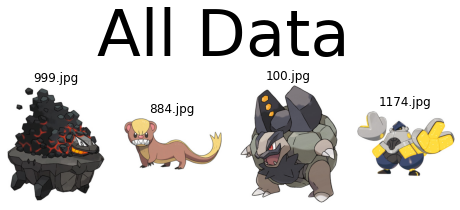

In [ ]:
import random
randomimg_index_lst = random.sample(range(len(df)), 4)
randomimg_index_lst = [str(i) +'.jpg' for i in randomimg_index_lst]

image_plotter(randomimg_index_lst)

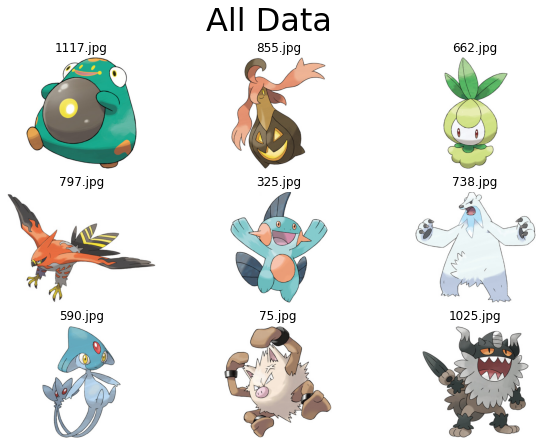

In [ ]:
randomimg_index_lst = random.sample(range(len(df)), 9)
randomimg_index_lst = [str(i) +'.jpg' for i in randomimg_index_lst]

square_image_plotter(randomimg_index_lst)

# Cleaning

Sadly, not all images can be used, so, we have to alter or delete. Here's are the some images to be considered


```
└───pokemon_img
    │   634.jpg
    │   802.jpg
    |   848.jpg
    |   ...
    |   1109.jpg
```

In [ ]:
spoil_file_id = [
    634, 802, # 2 genders at the same picture
    848, 849, 850, 851, 852, 853, 854, 855, # same pokemon but various forms
    1058, # The only Dynamax form + Outlier total stat 1125
    1100, 1164, # Sprites form
    1107, 1108, 1109 # Sprites form (different only hidden ability)
]

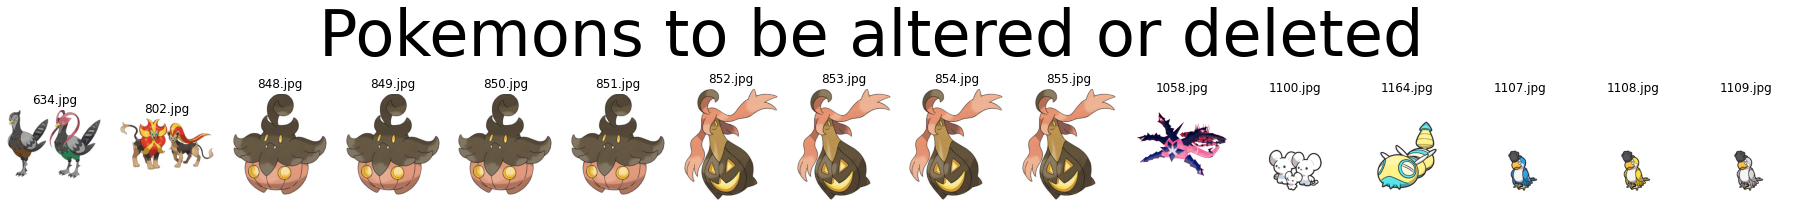

In [ ]:
spoil_index_lst = [str(i) +'.jpg' for i in spoil_file_id]

image_plotter(spoil_index_lst , 'Pokemons to be altered or deleted')

To avoid modifying the original folder `pokemon_img`, we copy and paste as `pokemon_img_mod`, and every modification and deletion will take place only that folder

```
Pokestat
│   df.csv
|
└───pokemon_img
|   │   0.jpg
|   │   1.jpg
|   |   ...
|   |   1193.jpg
|
└───pokemon_img_mod
    |   0.jpg
    │   1.jpg
    |   ...
    |   1193.jpg
```

In [ ]:
# Copy pokemon_img as pokemon_img_mod
import shutil

src = PATH + '/pokemon_img'
dest = PATH + '/pokemon_img_mod'

try:
    shutil.copytree(src, dest)
except FileExistsError:
    print("The folder already exists")

# Discussion on cleaning

This is what the author proposed how we clean them

<fieldset>

🚫 The most two leftmost showns the image with both male and female sex. (634.jpg, 802.jpg)

✅ Proposed solution : We may have to split them out as different images

---

🚫 Pumpkaboo, Gourgeist size variant, (848.jpg - 855.jpg)

✅ Proposed solution : We may have to adjust the size of image by the size based on teh description

---

🚫 Eternamax Eternatus

✅ This pokemon is an extreme outlier with unreasonable total stat 1125. It's better to remove them out to avoid the model to learn something that is extremely unusual

---

🚫 Maushold and Dudansparce Form

✅ According to [bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Maushold_(Pok%C3%A9mon)), the family of 3 and 4 both have same stat, but only 99% its first evolution will be evolved to 4 is 99%, while 3 is 1%. We may have to delete them due to incomplete artwork. This applied well as three segmented form of dudunsparce

---

🚫 Squawkabilly color variant 

✅ The only difference is its hidden ability which does not bother the stat. We decided to delete due to the incomplete artwork

![](https://i.ibb.co/Xsp2mtb/image.png)

The only thing you might want to debate is why don't we just resize pumpkaboo or gourgeist with a different scale size, so model can learn that the larger size tends to be more tanky, and the small size tends to be speedy

The author have inspected the nature of image for a while, and turnt out that it could lead to more bias, see the image of magikarp and gyarados, despite the big difference in size. The scale of image does not scale based on that. Check the following

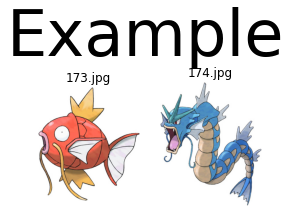

In [ ]:
eg_file_id = [173, 174]
spoil_index_lst = [str(i) +'.jpg' for i in eg_file_id]

image_plotter(spoil_index_lst , 'Example')

Above plot shows that these pokemon have similar size, but, the below plot show the reality which the size between them are far difference

![](https://i.ibb.co/xYdZ2nf/sssa.png)

This may not be the best choice, but the authors pick average size as the representative. 

The following function will be responsible to clean all of our proposed solution

In [ ]:
def clean_pokemon_img(PATH='/content/drive/MyDrive/PokeStat'):
    """
    remove Unfezant and Pyroar couple out of pokemon_img_mod
    then replace by the pokemon scraped from pokemon.com

    named as -1.jpg ,..., -4.jpg respectively
    """

    img_mod_PATH = PATH + "/pokemon_img_mod"  

    rm_files = [634,802,
                1058,1100,1107,1108,1109,1164, # All to delete
                849,850,851,853,854,855] # Keep Pumpkaboo-Gourgeist avg size only
    imgs_to_add = [
                    'https://assets.pokemon.com/assets/cms2/img/pokedex/full/521.png', #unfezant-m
                    'https://assets.pokemon.com/assets/cms2/img/pokedex/full/521_f2.png', #unfezant-fm
                    'https://assets.pokemon.com/assets/cms2/img/pokedex/full/668.png', #pyroar-m
                    'https://assets.pokemon.com/assets/cms2/img/pokedex/full/668_f2.png', #pyroar-fm
                  ]

    # remove 634.jpg , 802.jpg from pokemon_img_mod
    for file_ in rm_files:
        try:
            os.remove(f"{img_mod_PATH}/{file_}.jpg")
        except FileNotFoundError:
            print(f'Already removed {file_}.jpg or not created folder yet')
    
    # add the scraped pokemon as -1.jpg,-2.jpg,..,-4.jpg tp pokemon_img_mod
    for i,img in enumerate(imgs_to_add):
        img_data = requests.get(img).content
        with open(f"{img_mod_PATH}/{str(-i - 1)}.jpg", 'wb') as f:
            f.write(img_data)
    
    return 

In [ ]:
clean_pokemon_img()



---



We will use the pokemon_img_mod as our image set, hence the annotation dataset have to match with them. The following function will do a deep copy to the raw dataframe `df`, and clean with respect to our proposed solution called `df_mod`

In [ ]:
def clean_df(df, PATH='/content/drive/MyDrive/PokeStat'):
    """
    remove Unfezant and Pyroar couple out of pokemon_img_mod
    then replace by the pokemon scraped from pokemon.com

    named as -1.jpg ,..., -4.jpg respectively
    """

    rm_files = [
                1058,1100,1107,1108,1109,1164, # All to delete
                849,850,851,853,854,855 # Keep Pumpkaboo-Gourgeist avg size only
                ] 
    
    rm_files_spc = [634,802]  # special remove case

    df_mod = df.copy(deep=True)
    df_mod = df_mod.reset_index().rename(columns={'index': 'img_id'})
    df_mod = df_mod[~df_mod['img_id'].isin(rm_files)]

    df_pyroar = pd.concat([df_mod.query('img_id == 634')]*2) 
    df_unfezant =  pd.concat([df_mod.query('img_id == 802')]*2) 

    edited_df = pd.concat([df_pyroar,df_unfezant],ignore_index=True)
    edited_df.iloc[:,0] = list(range(-1,-5,-1))
    edited_df.iloc[:,2] = ['Unfezant-m','Unfezant-f','Pyroar-m','Pyroar-f']
    
    df_mod = pd.concat([edited_df , df_mod] , axis = 0, ignore_index = True)

    df_mod = df_mod[~df_mod['img_id'].isin(rm_files_spc)]
    return df_mod

In [ ]:
df_mod = clean_df(df)

In [ ]:
# Save df_mod.csv before moving on

df_mod.to_csv(PATH + '/df_mod.csv')

At this point, For new user, your directory should be ..

```
Pokestat
│   df.csv
|   df_mod.csv
|
└───pokemon_img
|   │   0.jpg
|   │   1.jpg
|   |   ...
|   |   1193.jpg
|
└───pokemon_img_mod
    |   0.jpg
    │   1.jpg
    |   ...
    |   1193.jpg
```

The author also checked that the past and future paradox only covered the pokemon from gen 1 - 7, so none of pokemon in paradox were originated from gen 8 (val set)



---



# Split train/val/test set

we discussed our decision to divide our train, validation, and test sets based on the timeline of Pokemon. 

| train   | val   | test  |
|---------|-------|-------|
| gen 1-7 | gen 8 | gen 9 |

However, there are other ways to divide the data as well. For example, split based on the distribution of category of pokemons (like legendary, sweeper, kiddy), so all set will have the equal proportion in those categories.

In the future notebook, we may use an ensemble model that includes one model specialized in time series analysis and another that specializes in categorizing Pokemon using clustering techniques. 

In this notebook, we focus on the time series aspect as we aim to predict future Pokemon.

Let's start by split test set out pf `df_mod`

In [ ]:
def split_dataset(df_mod):
    ## GEN 9 RULES POKEMON
    # 1. Paldean Form (Breed form, and Padeon wooper)
    # 2. National_id >= 906

    df_mod_ = df_mod.copy(deep=True)

    # condition 1 : Breed from
    test_df1 = df_mod_[df_mod_['main_name'].str.contains('Breed')]
    # condition 2 : Padeon wooper
    test_df2 =  df_mod_[df_mod_['img_id'] == 249] # Padeon wooper
    # condition 3 : After 906
    test_df3 =  df_mod_[df_mod_['national_id'] >= 906]

    df_test = pd.concat([test_df1, test_df2, test_df3]) 
    df_mod_.drop(df_test.index , inplace= True)    

    ## GEN 8 RULES POKEMON
    # 1. Galarian Form
    val_df1 = df_mod_[df_mod_['main_name'].str.contains('Galarian')]
    # 2. Hisulian Form
    val_df2 = df_mod_[df_mod_['main_name'].str.contains('Hisuian')]
    # 3. National_id
    val_df3 = df_mod_[df_mod_['national_id'] >= 810]
    # concat them
    df_val = pd.concat([val_df1, val_df2, val_df3]) 

    df_train = df_mod_.drop(df_val.index)

    return df_train,df_val,df_test

In [ ]:
df_train,df_val,df_test = split_dataset(df_mod)

In [ ]:
print(f'the proportion of train/val/test is : {len(df_train)}:{len(df_val)}:{len(df_test)}')

m = len(df_train) + len(df_val) + len(df_test)
print(f'the scaled proportion of train/val/test is : {len(df_train)/m : .3f}:{len(df_val)/m : .3f}:{len(df_test)/m : .3f}')

the proportion of train/val/test is : 927:143:114
the scaled proportion of train/val/test is :  0.783: 0.121: 0.096


# EDA of train/val/test set

Let's exploring each set by the set of image, density plot, and PCP plot

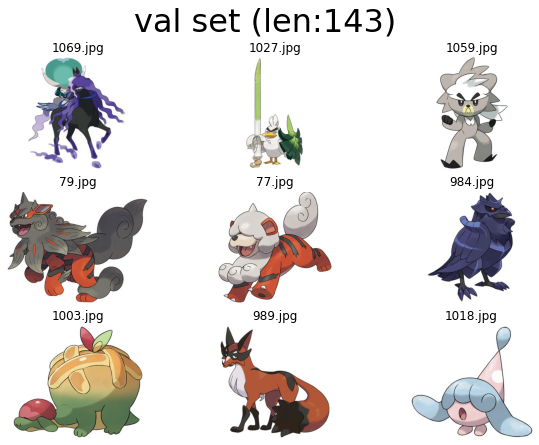

In [ ]:
set_ = "val" #@param ["train", "val", "test"]
set__ = globals()[f'df_{set_}']

randomimg_index_lst = random.sample(list(set__['img_id']), 9)
randomimg_index_lst = [str(i) +'.jpg' for i in randomimg_index_lst]
square_image_plotter(randomimg_index_lst,f'{set_} set (len:{len(set__)})')

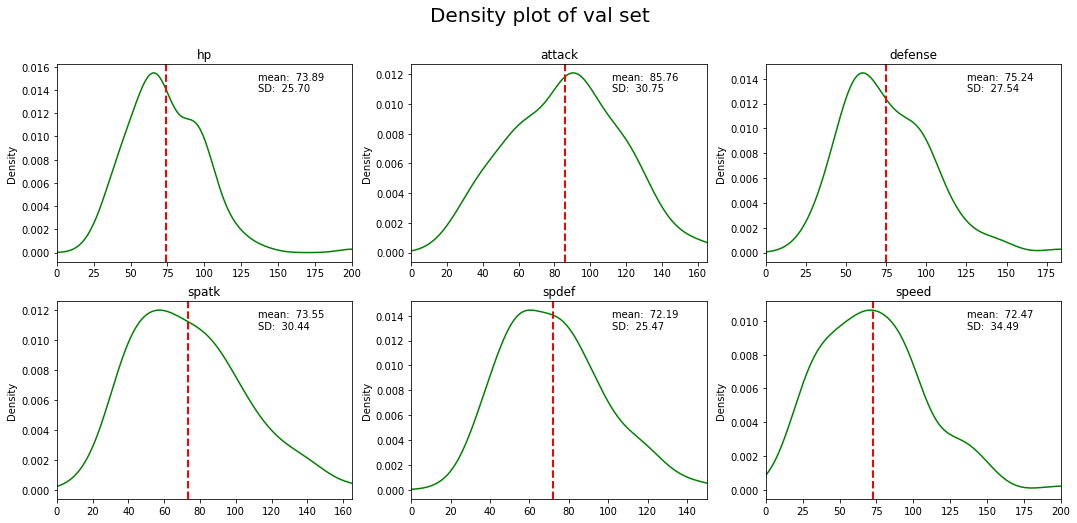

In [ ]:
%matplotlib inline

set_df = globals()[f'df_{set_}']
set_df = set_df[['hp','attack','defense','spatk','spdef','speed']]

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(18, 8))
fig.suptitle(f'Density plot of {set_} set ', fontsize=20)

for i, column in enumerate(['hp', 'attack', 'defense', 'spatk', 'spdef', 'speed']):
    set_df[column].plot.density(color='green',ax=axes[i//3, i%3],title = column)
    axes[i//3, i%3].axvline(set_df[column].mean(), color='red', linestyle='dashed', linewidth=2)
    axes[i//3, i%3].annotate(f'mean: {set_df[column].mean() : .2f}\nSD: {set_df[column].std() : .2f}', xy=(0.68, 0.86), xycoords='axes fraction')
    axes[i//3, i%3].set_xlim(0, set_df[column].max())


In [ ]:
import plotly.express as px
fig = px.parallel_coordinates(set_df)
fig



---



Here's the summary of each set

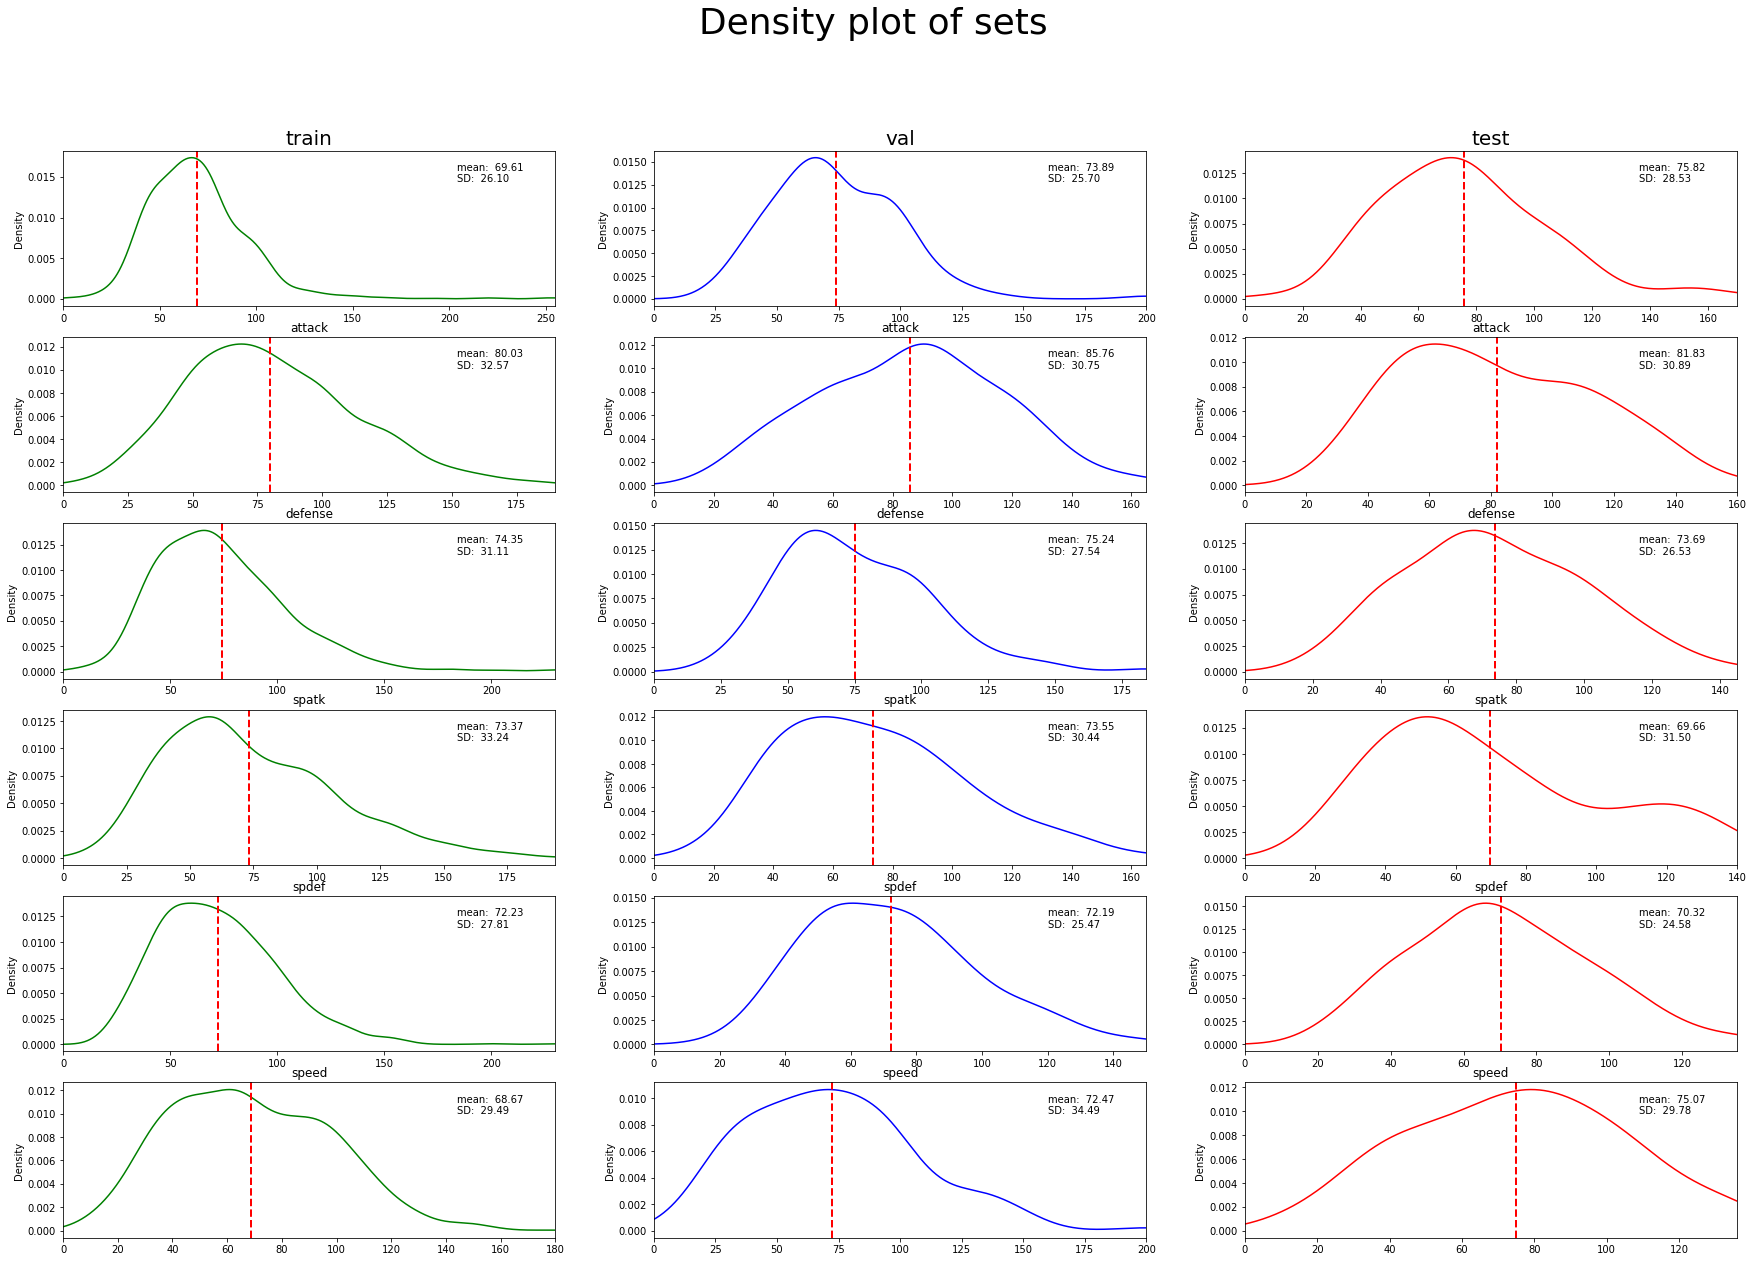

In [ ]:
%matplotlib inline

colors = {'train': 'green', 'val': 'blue', 'test': 'red'}

fig, axes = plt.subplots(nrows=6, ncols=3,figsize=(30, 20))
fig.suptitle(f'Density plot of sets', fontsize=36)
set_index = 0
for set_ in ["train", "val", "test"]:
    set_df = globals()[f'df_{set_}']
    set_df = set_df[['hp','attack','defense','spatk','spdef','speed']]

    for i, column in enumerate(['hp', 'attack', 'defense', 'spatk', 'spdef', 'speed']):
        set_df[column].plot.density(color= colors[set_] ,ax=axes[i,set_index],title = column)
        axes[i,set_index].axvline(set_df[column].mean(), color='red', linestyle='dashed', linewidth=2)
        axes[i,set_index].annotate(f'mean: {set_df[column].mean() : .2f}\nSD: {set_df[column].std() : .2f}', xy=(0.8, 0.8), xycoords='axes fraction')
        axes[i,set_index].set_xlim(0, set_df[column].max())
        axes[0, set_index].set_title(set_,fontsize=20)

    set_index+=1
plt.show()

Based on the following summary plot. Although, the distribution of them seems to behave a bit different, the mean and standard deviation of them are seem to to be closed together.

# Upload each training, val, test image to its folder

We are going to move all images into their belonged set

In [ ]:
# Create new folders; train/val/test

try:
    print('Creating Train/Val/Test set ..')
    lst_set = ['train','val','test']
    os.mkdir(f'{PATH}/image_set')

    for set_ in lst_set:
       os.mkdir(f'{PATH}/image_set/{set_}')

except FileExistsError:
    print('The folder already exists')

Creating Train/Val/Test set ..


In [ ]:
lst_set = ['train','val','test']
lst_set_ = [ globals()[f'df_{set_}'] for set_ in lst_set]

for i in range(len(lst_set)):
    set_name = lst_set[i]
    set_ = lst_set_[i]
    img_id_lst = set_['img_id'].to_list()

    for img_id in img_id_lst:
        
        src = f'{PATH}/pokemon_img_mod/{img_id}.jpg'
        dest = f'{PATH}/image_set/{set_name}/{img_id}.jpg'

        shutil.move(src,dest) 
        
    print(f'done moving {set_name} set')

done moving train set
done moving val set
done moving test set


In [ ]:
shutil.rmtree(f'{PATH}/pokemon_img_mod') # We no longer need this folder

# Upload each training, val, test dataframe to its folder

Similar to image_set, we need to move all df_mod as train/val/test set in the folder annotation_set

```
Pokestat
│   df.csv
|   df_mod.csv
|
└───pokemon_img
|   │   0.jpg
|   │   1.jpg
|   |   ...
|   |   1193.jpg
|
└───image_set
    |   
    │───train
    │     │  -1.jpg
    │     │  -2.jpg
    │     │   ..
    │     │  970.jpg
    │
    │───val
    │     │  69.jpg
    │     │  77.jpg
    │     │   ..
    │     │  1078.jpg
    │
    │───test
    │     │  170.jpg
    │     │  171.jpg
    │     │   ..
    │     │  1193.jpg
```

In [ ]:
def df_to_annotation(df):
    df_annotation = df.copy(deep=True)
    df_annotation[['hp','attack','defense', 'spatk','spdef','speed']] = df_annotation[['hp','attack','defense', 'spatk','spdef','speed']].astype(float)
    df_annotation = df_annotation[['img_id','hp','attack','defense', 'spatk','spdef','speed']]
    df_annotation['img_id'] = df_annotation['img_id'].astype(str) + '.jpg'
    df_annotation = df_annotation.rename(columns={'img_id':'file_name'})
    return df_annotation

In [ ]:
train_annotation = df_to_annotation(df_train)
val_annotation = df_to_annotation(df_val)
test_annotation = df_to_annotation(df_test)

In [ ]:
from google.colab import drive
import os

try: 
    os.mkdir(f'{PATH}/annotate_set')
    train_annotation.to_csv(f'{PATH}/annotate_set/train_annotation.csv')
    val_annotation.to_csv(f'{PATH}/annotate_set/val_annotation.csv')
    test_annotation.to_csv(f'{PATH}/annotate_set/test_annotation.csv')

except FileExistsError:
    print("The folder was already existed")

In [ ]:
os.remove(f'{PATH}/df_mod.csv') # We no longer need this folder

# Handling the image with 4 channel

Some images in our image_set contains transparent background. This mean not every image have the channel. One way to fix this problem is to replace transparent background by white background

In [ ]:
from skimage import io
from PIL import Image

In [ ]:
def get_transparent_filename(PATH='/content/drive/MyDrive/PokeStat'):

    set_lst = ['train','val','test']
    annotation_df_lst = [globals()[f'{set_}_annotation'] for set_ in set_lst]

    file_lst = []
    for set_ in set_lst:
        annotation = globals()[f'{set_}_annotation']
        for file_name in annotation['file_name']:
            img_shape = io.imread(f'{PATH}/image_set/{set_}/{file_name}').shape 
            if len(img_shape) != 3 or img_shape[2] !=3 :
                file_lst.append(file_name)
    return file_lst

In [ ]:
def replace_transparency_by_white(img_path):
    img = Image.open(img_path).convert("RGBA")
    new_img = Image.new("RGBA", img.size, "WHITE")
    new_img.paste(img, mask=img)

    new_img.convert("RGB").save(img_path)

In [ ]:
# Only images belong to train set have transparent background

tsp_imgs = get_transparent_filename()

for tsp_img in tsp_imgs:
    replace_transparency_by_white(f'{PATH}/image_set/train/{tsp_img}')

In [ ]:
# Recheck

assert not get_transparent_filename(), 'Still there is an image with transparent background, make sure you replace img background on val set or test set too, if have'

🎉🎉Congratulation, Finally, our data is ready for training model in the next notebook

Before leaving to the next colab notebook, please recheck if your following directory is like this

```
Pokestat
│   df.csv
|
└───pokemon_img
|   │   0.jpg
|   │   1.jpg
|   |   ...
|   |   1193.jpg
|
└───image_set
|   |   
|   │───train
|   │     │  -1.jpg
|   │     │  -2.jpg
|   │     │   ..
|   │     │  970.jpg
|   │
|   │───val
|   │     │  69.jpg
|   │     │  77.jpg
|   │     │   ..
|   │     │  1078.jpg
|   │
|   │───test
|   │     │  170.jpg
|   │     │  171.jpg
|   │     │   ..
|   │     │  1193.jpg
|
└───image_set
|      │ train_annotation.csv
|      │ val_annotation.csv
|      │ test_annotation.csv
```

Next colab notebook : https://colab.research.google.com/drive/1gtSM05ixfIVqt7Wu1YzKnbytoyXuQPE8